# Advanced retrieval

## Utils

In [28]:
import chromadb

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import numpy as np
from pypdf import PdfReader
import tqdm 


def _read_pdf(filename):
    reader = PdfReader(filename)
    
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]
    return pdf_texts


def _chunk_texts(texts):
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    return token_split_texts


def load_chroma(filename, collection_name, embedding_function):
    texts = _read_pdf(filename)
    chunks = _chunk_texts(texts)

    chroma_cliet = chromadb.Client()
    chroma_collection = chroma_cliet.create_collection(name=collection_name, embedding_function=embedding_function)

    ids = [str(i) for i in range(len(chunks))]

    chroma_collection.add(ids=ids, documents=chunks)

    return chroma_collection

def word_wrap(string, n_chars=72):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)

   
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

## Creating and loading collection

In [30]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from utils import load_chroma
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='data/microsoft_annual_report_2022.pdf', 
                                collection_name='micro', 
                                embedding_function=embedding_function)
chroma_collection.count()

10

In [31]:
import umap as umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/home/shuaib/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/shuaib/.local/lib/python3.10/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [32]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


In [33]:
query = "What investments were made in research and development"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

along with twenty - seven members of the european union, including
france, germany, italy, as well as countries like the united kingdom,
canada, japan, korea, australia, new zealand, and many others, even
switzerland. we are inflicting pain on russia and sup porting the
people of ukraine. putin is now isolated from the world more than ever.
together with our allies, we are right now enforcing powerful economic
sanctions. we are cutting off russia ’ s largest banks from the
international financial system. preventing russia ’ s central bank from
defending the russian ruble, making putin ’ s $ 630 bill ion “ war fund
” worthless. we are choking off russia ’ s access to technology that
will sap its economic strength and weaken its military for years to
come. tonight i say to the russian oligarchs and corrupt leaders who
have bilked billions of dollars off this violent regime : no more. the
u. s. department of justice is assembling a dedicated task force to go
after

to all americans, i wil

In [34]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


(13.972675943374634, 18.821060514450075, 8.476618766784668, 13.270991325378418)

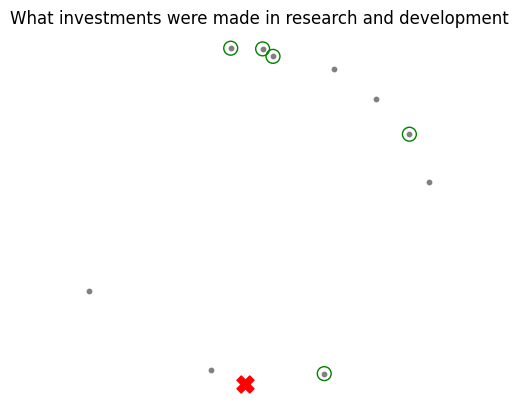

In [35]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

# Query Expansion

## Expansion with Generated Answer

In [36]:
prompt = """You are a helpful expert financial research assistant. Provide an example answer to the given question, \
        that might be found in a document like an annual report of Microsoft. keep it very simple and generic
        Question: {query}"""
query="Was there significant turnover in the executive team?"
generate_answer_prompt= prompt.format(query=query)

In [37]:
import google.generativeai as genai
import streamlit as st
genai.configure(api_key = st.secrets["GEMINI_API_KEY"] )
model = genai.GenerativeModel('gemini-pro')
answer = model.generate_content(generate_answer_prompt)
hypothetical_answer=answer.text

In [38]:
joint_query = f"{query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? **Annual Report
Excerpt:**

**Executive Turnover**

During the fiscal year, [number]
executives departed the company. This represents a turnover rate of
approximately [percentage]%. The reasons for departure included [list
of reasons]. The company has taken steps to fill these vacancies and
remains committed to maintaining a strong and experienced executive
team.


In [39]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc)) 
    print('')

the crimes of russian oligarchs. we are joining with our european
allies to find and seize your yachts, your luxury apartments, your
private jets. we are coming for your ill - begotten gains. and tonight
i am announcing that we will join our allies in closing off american
airspace to all russian flights – further isolating russia – and adding
an additional squeeze on their economy. the ruble has lost 30 % of its
value. the russian stock market h as lost 40 % of its value and trading
remains suspended. russia ’ s economy is reeling and putin alone is to
blame. together with our allies, we are providing support to the
ukrainians in their fight for freedom. military assistance. economic
assistance. humanitarian assistance. we are giving more than $ 1
billion in direct assistance to ukraine. and we will continue to aid
the ukrainian people as they defend their country and to help ease
their suffering.

let me be clear, our forces are not engaged and will not engage in
conflict with russian

In [40]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


(13.972675943374634, 18.821060514450075, 8.429567956924439, 13.273231840133667)

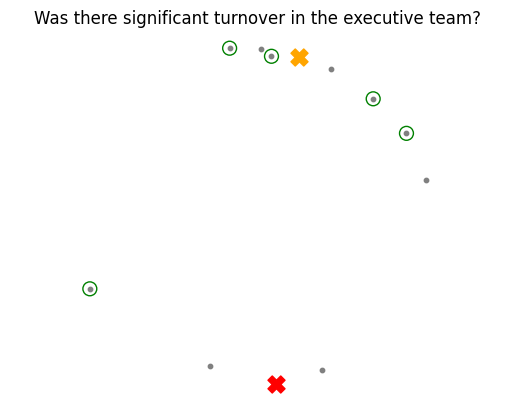

In [41]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim') 
plt.title(f'{query}')   
plt.axis('off')

## Multi Query

In [42]:
def augment_multiple_query(query, model='gemini-pro'):
    prompt ="""Suggest up to five additional related questions to help them find the information they need, for the provided question. \
            Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.\
            Make sure they are complete questions, and that they are related to the original question.\
            Output one question per line. Do not number the questions.
            Query: {query}"""
    model = genai.GenerativeModel('gemini-pro')
    generate_multi_query=prompt.format(query=query)
    answer = model.generate_content(generate_multi_query)
    content = answer.text
    content = content.split("\n")
    return content

In [43]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- What specific products or services drove the highest revenue growth?
- Did changes in market conditions play a significant role in revenue increases?
- How did pricing strategies impact revenue performance?
- What operational improvements contributed to cost savings and increased profitability?


In [44]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
the crimes of russian oligarchs. we are joining with our european
allies to find and seize your yachts, your luxury apartments, your
private jets. we are coming for your ill - begotten gains. and tonight
i am announcing that we will join our allies in closing off american
airspace to all russian flights – further isolating russia – and adding
an additional squeeze on their economy. the ruble has lost 30 % of its
value. the russian stock market h as lost 40 % of its value and trading
remains suspended. russia ’ s economy is reeling and putin alone is to
blame. together with our allies, we are providing support to the
ukrainians in their fight for freedom. military assistance. economic
assistance. humanitarian assistance. we are giving more than $ 1
billion in direct assistance to ukraine. and we will continue to aid
the ukrainian people as they defend their country and to help ease
their suff

In [45]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


In [46]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


(13.806181144714355, 18.8289888381958, 8.613110399246215, 13.427124166488648)

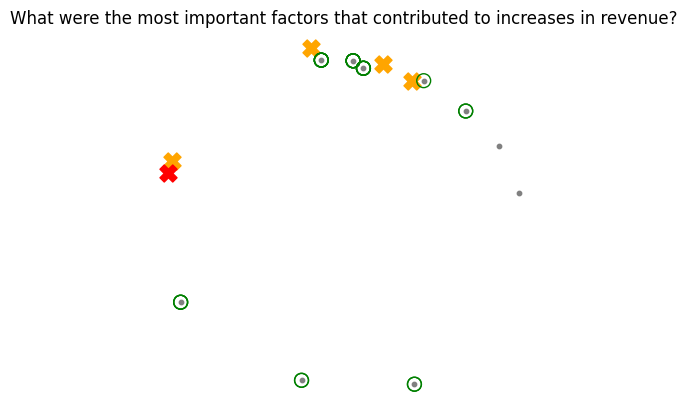

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

# Cross Encoder re ranking

In [48]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

to all americans, i will be honest with you, as i ’ ve always promised.
a russian dictator, invading a foreign country, has costs around the
world. and i ’ m taking robust action to make sure the pain of our
sanctions is targeted at russia ’ s economy. and i wil l use every tool
at our disposal to protect american businesses and consumers. tonight,
i can announce that the united states has worked with 30 other
countries to release 60 million barrels of oil from reserves around the
world. america will lead that effort, releasing 30 million barrels from
our own strategic petroleum reserve. and we stand ready to do more if
necessary, unified with our allies. these steps will help blunt gas
prices here at home. and i know the news about what ’ s happening can
seem alarming. but i want you to know that we are going to be okay.
when the history of this era is written putin ’ s war on ukraine will
have left russia weaker and the rest of

along with twenty - seven members of the european union

In [49]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')    
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
ranks = np.argsort(scores)[::-1] +1

/home/shuaib/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [50]:
ranked_docs = {rank_num:doc for rank_num,doc in zip(ranks,retrieved_documents)}

In [51]:
from typing import List
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')    
def rank_documents(cross_encoder:CrossEncoder,query:str,retrieved_documents:List[str]):

    pairs = [[query, doc] for doc in retrieved_documents]
    scores = cross_encoder.predict(pairs)
    ranks = np.argsort(scores)[::-1]
    ranked_docs = {rank_num:doc for rank_num,doc in zip(ranks,retrieved_documents)}
    return ranked_docs
ranked_docs= rank_documents(cross_encoder,query,retrieved_documents)

In [52]:
ranked_docs= rank_documents(cross_encoder,query,retrieved_documents)

In [53]:
ranked_docs

{1: 'to all americans, i will be honest with you, as i ’ ve always promised. a russian dictator, invading a foreign country, has costs around the world. and i ’ m taking robust action to make sure the pain of our sanctions is targeted at russia ’ s economy. and i wil l use every tool at our disposal to protect american businesses and consumers. tonight, i can announce that the united states has worked with 30 other countries to release 60 million barrels of oil from reserves around the world. america will lead that effort, releasing 30 million barrels from our own strategic petroleum reserve. and we stand ready to do more if necessary, unified with our allies. these steps will help blunt gas prices here at home. and i know the news about what ’ s happening can seem alarming. but i want you to know that we are going to be okay. when the history of this era is written putin ’ s war on ukraine will have left russia weaker and the rest of',
 2: 'along with twenty - seven members of the eur